## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on mock P1D data from a given model

In [1]:
%matplotlib inline

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import os
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import mock_data
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

In [82]:
folder_figs = os.path.abspath(".") + "/fig_max_like_mock/"

# emulator_label = "mpg_gp"
# emulator_label = "mpg_nn"
emulator_label = "nyx_nn"

data_label = "QMLE_Ohio"
# data_label = "Chabanier2019"

sim_igm = emulator_label[:3]

# specify if you want to add high-resolution P1D (only working for Pedersen23 emulator)
# add_hires = True
add_hires = False

if add_hires:
    emu_kmax_Mpc = 8
    emu_ndeg = 7
    flag_fig = data_label + "_" + emulator_label + "_hr"
else:
    extra_data = None
    emu_kmax_Mpc = 4
    emu_ndeg = 5
    flag_fig = data_label + "_" + emulator_label + "_lr"

### Setup emulator

The emulator will be used both to make a mock, and in the likelihood 

In [83]:
if emulator_label == "mpg_gp":
    emulator = gp_emulator.GPEmulator(
        training_set="Pedersen21", kmax_Mpc=emu_kmax_Mpc, ndeg=emu_ndeg
    )
elif emulator_label == "mpg_nn":
    assert not add_hires, "NN emulator not trained beyond k=4 1/Mpc"
    emulator = nn_emulator.NNEmulator(
        training_set="Cabayol23", emulator_label="Cabayol23"
    )
elif emulator_label == "nyx_nn":
    assert not add_hires, "Nyx emulator not trained beyond k=4 1/Mpc"
    emulator = nn_emulator.NNEmulator(
        training_set="Nyx23", emulator_label="Cabayol23_Nyx"
    )
else:
    raise ValueError("wrong emulator_label", emulator_label)

Selected training set from Nyx23
Select emulator in Cabayol23_Nyx
Neural network emulating the optimal P1D of Nyx simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones


### Create mock P1D data

Use Lya theory to mimic mock data

In [84]:
data = mock_data.Mock_P1D(
    emulator=emulator, data_label=data_label, sim_igm=sim_igm
)

will read P1D file /home/jchaves/Proyectos/projects/lya/chains/private_data/p1d_measurements//QMLE_Ohio//desi-y5fp-1.5-4-o3-deconv-power-qmle_kmax0.04.txt
2 low-k bins not included


ValueError: A value in x_new is below the interpolation range.

In [ ]:
data.plot_p1d()

In [ ]:
# check if we also need mock extra_p1d
if add_hires:
    extra_data = mock_data.Mock_P1D(
        emulator=emulator, data_label="Karacayli2022"
    )
else:
    extra_data = None

### Set free parameters and theory

In [ ]:
# stick to primordial power-law parameters here
free_param_names = ["As", "ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm = 2
for i in range(n_igm):
    for par in ["tau", "sigT_kms", "gamma", "kF"]:
        free_param_names.append("ln_{}_{}".format(par, i))

In [ ]:
theory = lya_theory.Theory(
    zs=data.z,
    emulator=emulator,
    free_param_names=free_param_names,
    sim_igm=sim_igm,
)

In [ ]:
# print parameter values used to create mock data
for p in theory.get_parameters():
    print(p.info_str(all_info=True))

### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and theory objects to the likelihood.

In [ ]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms = None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor = 0
like = likelihood.Likelihood(
    data=data,
    theory=theory,
    free_param_names=free_param_names,
    prior_Gauss_rms=prior_Gauss_rms,
    emu_cov_factor=emu_cov_factor,
    extra_p1d_data=extra_data,
)

In [ ]:
# check starting point for free parameters (should be equal to truth)
test_values = len(free_param_names) * [0.5]
for p in like.parameters_from_sampling_point(values=test_values):
    print(p.info_str(all_info=True))
print("chi2 =", like.get_chi2(values=test_values))
like.plot_p1d(values=test_values, residuals=True, plot_every_iz=2)

In [ ]:
if extra_data:
    like.extra_p1d_like.plot_p1d(residuals=True, plot_every_iz=2)

### Run iminuit minimizer

In [ ]:
# choose starting point for free parameters (within 0.5 +/- ini_sigma, in the unit cube)
ini_sigma = 0.00002
ini_values = (
    2 * ini_sigma * np.random.random(len(like.free_params)) + 0.5 - ini_sigma
)
print("ini values", ini_values)
for p in like.parameters_from_sampling_point(values=ini_values):
    print(p.info_str(all_info=True))

In [ ]:
minimizer = iminuit_minimizer.IminuitMinimizer(like, ini_values=ini_values)

In [ ]:
minimizer.minimize(compute_hesse=True)

In [ ]:
# what is the chi2 of the best-fit? (should be close to 0)
best_fit_values = np.array(minimizer.minimizer.values)
like.get_chi2(values=best_fit_values)

In [ ]:
# what was the chi2 of the starting point?
like.get_chi2(values=ini_values)

### Save results

In [ ]:
pars = ["As", "ns"]
for ii in range(2):
    pars += ["ln_tau_" + str(ii)]
    pars += ["ln_sigT_kms_" + str(ii)]
    pars += ["ln_gamma_" + str(ii)]
    pars += ["ln_kF_" + str(ii)]

In [ ]:
arr_parx = []
arr_pary = []
arr_sig_x = []
arr_sig_y = []
arr_r = []
for parx in pars:
    ix = minimizer.index_by_name(parx)
    sig_x = minimizer.minimizer.errors[ix]
    for pary in pars:
        if parx == pary:
            continue
        iy = minimizer.index_by_name(pary)
        sig_y = minimizer.minimizer.errors[iy]
        r = minimizer.minimizer.covariance[ix, iy] / sig_x / sig_y
        arr_parx.append(parx)
        arr_pary.append(pary)
        arr_sig_x.append(sig_x)
        arr_sig_y.append(sig_y)
        arr_r.append(r)
#         print(parx, pary, sig_x, sig_y, r)
# sig_y=minimizer.minimizer.errors[iy]
# r=minimizer.minimizer.covariance[ix,iy]/sig_x/sig_y

In [ ]:
np.savez(
    folder_figs + flag_fig,
    arr_parx=np.array(arr_parx),
    arr_pary=np.array(arr_pary),
    arr_sig_x=np.array(arr_sig_x),
    arr_sig_y=np.array(arr_sig_y),
    arr_r=np.array(arr_r),
)

### Plot results

In [ ]:
minimizer.plot_best_fit(plot_every_iz=2)

In [ ]:
minimizer.plot_ellipses("As", "ns")

In [ ]:
# minimizer.plot_ellipses("ln_gamma_0", "ln_sigT_kms_0")

In [ ]:
# minimizer.plot_ellipses('ln_tau_0','ln_tau_1',cube_values=True)

In [27]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -450.9                     │              Nfcn = 472              │
│ EDM = 1.95e-05 (Goal: 0.0001)    │            time = 4.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.500   │   0.007   │            │            │         │         │       │
│ 1 │ x1   │   0.50    │   0.01    │            │            │         │         │       │
│ 2 │ x2   │   0.500   │   0.008   │            │            │         │         │       │
│ 3 │ x3   │   0.500   │   0.005   │            │            │         │         │       │
│ 4 │ x4   │   0.50    │   0.01    │            │            │         │         │       │
│ 5 │ x5   │   0.500   │   0.019   │            │            │         │         │       │
│ 6 │ x6   │   0.500   │   0.014   │            │            │         │         │       │
│ 7 │ x7   │   0.500   │   0.021   │            │            │         │         │       │
│ 8 │ x8   │   0.500   │   0.024   │            │            │         │         │       │
│ 9 │ x9   │   0.50    │   0.04    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │  5.16e-05 -3.88e-05 -5.31e-05 -2.69e-05 -5.25e-05  3.25e-05 -7.14e-05  6.58e-06  -0.00014 -8.11e-07 │
│ x1 │ -3.88e-05  9.38e-05  4.31e-05  1.04e-05  5.84e-05 -0.000137  7.15e-05 -1.57e-05  0.000152  1.72e-05 │
│ x2 │ -5.31e-05  4.31e-05  7.05e-05  2.36e-05   7.1e-05  -5.4e-05  9.21e-05  2.22e-06  0.000167 -9.16e-06 │
│ x3 │ -2.69e-05  1.04e-05  2.36e-05  2.45e-05  2.14e-05 -3.01e-06  3.43e-05  2.75e-05  6.67e-05 -2.04e-05 │
│ x4 │ -5.25e-05  5.84e-05   7.1e-05  2.14e-05  9.48e-05 -4.53e-05  9.35e-05  1.69e-06  0.000206 -4.98e-05 │
│ x5 │  3.25e-05 -0.000137  -5.4e-05 -3.01e-06 -4.53e-05  0.000361 -9.69e-05 -2.97e-05 -0.000147 -4.66e-05 │
│ x6 │ -7.14e-05  7.15e-05  9.21e-05  3.43e-05  9.35e-05 -9.69e-05  0.000201 -5.75e-05  0.000302 -5.75e-05 │
│ x7 │  6.58e-06 -1.57e-05  2.22e-06  2.75e-05  1.69e-06 -2.97e-05 -5.75e-05  0.000423 -2.94e-05 -1.89e-05 │
│ x8 │  -0.00014  0.000152  0.000167  6.67e-05  0.000206 -0.000147  0.000302 -2.94e-05  0.000589 -1.51e-06 │
│ x9 │ -8.11e-07  1.72e-05 -9.16e-06 -2.04e-05 -4.98e-05 -4.66e-05 -5.75e-05 -1.89e-05 -1.51e-06   0.00186 │
└────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [28]:
minimizer.minimizer.errors

<ErrorView x0=0.007182573383119303 x1=0.009683395320052057 x2=0.008397456650263806 x3=0.004946961451697836 x4=0.009735875099340019 x5=0.018997985027659828 x6=0.01416937392021164 x7=0.02055879700507478 x8=0.02426883254905494 x9=0.043071015780772194>

In [29]:
minimizer.best_fit_value('ln_tau_0',return_hesse=True)

(8.547653724544357e-07, 0.0016794913300527611)

In [30]:
minimizer.best_fit_value('ns',return_hesse=True)

(0.9649998966346979, 0.00164617720440885)

## Plot results all

In [69]:
from matplotlib.patches import Ellipse

In [78]:
data_label = "QMLE_Ohio"
data_label = "Chabanier2019"

folder_figs = os.path.abspath(".") + "/fig_max_like_mock/" + data_label + "_"

# emulator_label = ["mpg_gp_hr", "mpg_gp_lr", "mpg_nn_lr", "nyx_nn_lr"]
emulator_label = ["mpg_gp_lr", "mpg_nn_lr", "nyx_nn_lr"]

dat = []
for lab in emulator_label:
    dat.append(np.load(folder_figs + lab + ".npz"))

In [79]:
dat[0].files

['arr_parx', 'arr_pary', 'arr_sig_x', 'arr_sig_y', 'arr_r']

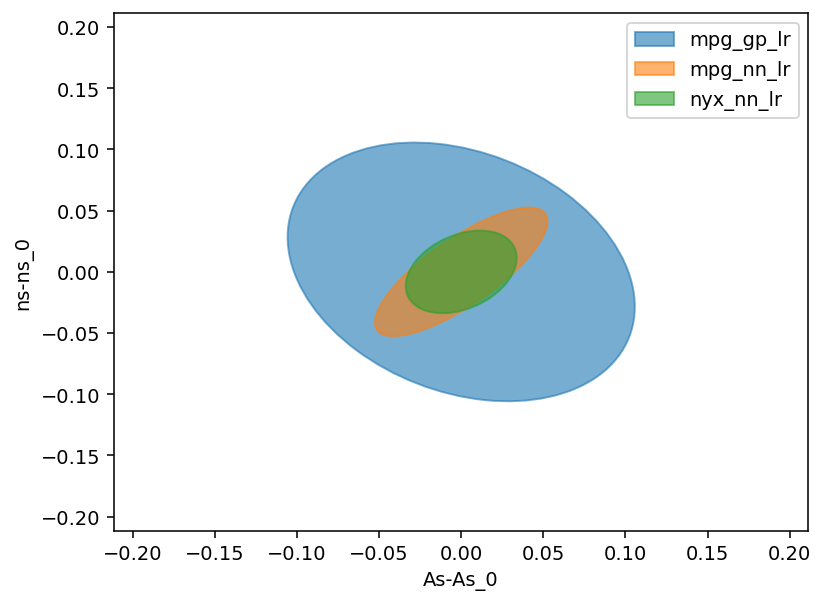

In [81]:
sig_xm = 0
sig_ym = 0

for jj, lab in enumerate(emulator_label):

    ii = 0
    nsig = 1
    pname_x = dat[jj]["arr_parx"][ii]
    pname_y = dat[jj]["arr_pary"][ii]
    sig_x = dat[jj]["arr_sig_x"][ii]
    if sig_x > sig_xm:
        sig_xm = sig_x * 1
    sig_y = dat[jj]["arr_sig_x"][ii]
    if sig_y > sig_ym:
        sig_ym = sig_y * 1
    r = dat[jj]["arr_r"][ii]
    val_x = 0
    val_y = 0

    w, v = np.linalg.eig(
        np.array(
            [[sig_x**2, sig_x * sig_y * r], [sig_x * sig_y * r, sig_y**2]]
        )
    )

    # semi-major and semi-minor axis of ellipse
    a = np.sqrt(w[0])
    b = np.sqrt(w[1])

    # figure out inclination angle of ellipse
    alpha = np.arccos(v[0, 0])
    if v[1, 0] < 0:
        alpha = -alpha
    # compute angle in degrees (expected by matplotlib)
    alpha_deg = alpha * 180 / np.pi

    # make plot
    fig = plt.subplot(111)
    for isig in range(1, nsig + 1):
        if isig == 1:
            lab0 = lab
        else:
            lab0 = None
        ell = Ellipse(
            (val_x, val_y),
            2 * isig * a,
            2 * isig * b,
            alpha_deg,
            label=lab0,
            color="C" + str(jj),
        )
        ell.set_alpha(0.6 / isig)
        fig.add_artist(ell)

plt.legend()
plt.xlabel(pname_x + "-" + pname_x + "_0")
plt.ylabel(pname_y + "-" + pname_y + "_0")
plt.xlim(val_x - (nsig + 1) * sig_xm, val_x + (nsig + 1) * sig_xm)
plt.ylim(val_y - (nsig + 1) * sig_ym, val_y + (nsig + 1) * sig_ym)
plt.savefig(folder_figs + "As_ns.png")